In [1]:
import pandas as pd
import sqlite3

con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
player_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [2]:
player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [3]:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

def prepare_dataframe(df):
    df = df[df.defensive_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['defensive_work_rate'], prefix='defensive_work_rate')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['preferred_foot'], prefix='preferred_foot')],axis=1)
    df = df[df.attacking_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['attacking_work_rate'], prefix='attacking_work_rate')],axis=1)
    df = df.drop(df_one_hot_list, axis=1)
    return df

player_df = prepare_dataframe(player_df)

In [4]:
# Ok IDEE: Neue Daten generieren OHNE die Verwendung von GANs. Dazu erstelle ich Buckets (n-Viele) und gebe die percentiles wieder. 

def get_col_quantile(df, col, buckets):
    step = 1 / buckets
    container = []
    
    for i in range(buckets):
        container.append(df[col].quantile(step * i))
    
    return container

quantile = get_col_quantile(player_df, 'overall_rating', 10)
quantile

[47.0, 61.0, 63.0, 65.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0]

In [5]:
print([player_df['overall_rating'].mean(), player_df['overall_rating'].max(), player_df['overall_rating'].min(), player_df['overall_rating'].std()])

[68.27505803976986, 94.0, 47.0, 6.282576855113117]


In [6]:
def split_df_in_buckets(df, col, buckets):
    split = df.shape[0] / buckets
    container = []
    
    for i in range(buckets):
        container.append(df.sort_values(by=[col])[int(i*split):int((i+1)*split)])
        
    return container

In [7]:
buckets = split_df_in_buckets(player_df, 'overall_rating', 10)
buckets[1]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
3023,3027,177843,Enes Sipovic,226628,1990-09-11 00:00:00,198.12,203,177843,2015-05-15 00:00:00,50485,...,11.0,9.0,0,0,1,0,1,0,0,1
9228,9238,301241,Ross Barbour,212907,1993-02-01 00:00:00,177.80,157,301241,2016-03-10 00:00:00,153755,...,16.0,11.0,0,0,1,0,1,0,0,1
1299,1302,89548,Bojan Bozovic,164407,1985-02-03 00:00:00,190.50,185,89548,2015-07-03 00:00:00,22037,...,14.0,13.0,0,0,1,0,1,1,0,0
7391,7401,192679,Michael Tidser,213460,1990-01-15 00:00:00,182.88,168,192679,2015-01-09 00:00:00,123822,...,8.0,13.0,0,0,1,1,0,1,0,0
6849,6858,32658,Mark Brown,45162,1981-02-28 00:00:00,185.42,172,32658,2014-12-05 00:00:00,114391,...,60.0,60.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,10978,26674,Youssef El Akchaoui,109809,1981-02-18 00:00:00,175.26,159,26674,2012-08-31 00:00:00,182524,...,10.0,12.0,0,0,1,1,0,0,0,1
9600,9611,68827,Sebastian Ziajka,204145,1982-12-15 00:00:00,182.88,165,68827,2016-05-05 00:00:00,159873,...,15.0,9.0,0,1,0,1,0,1,0,0
992,995,173983,Arthur,192038,1987-01-14 00:00:00,177.80,150,173983,2016-03-24 00:00:00,17121,...,6.0,13.0,0,0,1,1,0,1,0,0
9598,9609,299021,Sebastian Steblecki,208907,1992-01-16 00:00:00,185.42,154,299021,2016-03-03 00:00:00,159845,...,7.0,16.0,0,0,1,0,1,1,0,0


In [8]:
for df in buckets:
    print(df['overall_rating'].mean())
    print(df['overall_rating'].std())

57.41818181818182
2.6908211441868066
61.98789101917255
0.7887175962897163
64.0100908173562
0.6371488669161706
65.58484848484848
0.4929971966119816
67.27547931382442
0.508308888956166
68.85671039354187
0.6127046150767197
70.62525252525252
0.591453016089472
72.63471241170535
0.6290652782344168
74.91422805247225
0.795002944191316
79.43188698284561
2.633343377683589


In [9]:
player_df.dtypes

id                              int64
player_api_id                   int64
player_name                    object
player_fifa_api_id              int64
birthday                       object
height                        float64
weight                          int64
player_api_id                   int64
date                           object
id                              int64
player_fifa_api_id              int64
player_api_id                   int64
date                           object
overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed

In [10]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd
#referring to https://stats.stackexchange.com/questions/215938/generate-synthetic-data-to-match-sample-data

df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
column_names = list(df.columns)

def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
       #create synthetic samples only for a subset of T.
       #TODO: select random minortiy samples
       N = 100
       pass

    if (N % 100) != 0:
       raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(int(N)):
            nn_index = choice(nn[0]) #Take one of the nearest neighbour
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i] # calculates the difference between current and neighbour
            gap = np.random.random() # bring some randomness to the mix
            S[int(n + i * N), :] = T[i,:] + gap * dif[:] # set the new data
    return S

df = df.to_numpy()
new_data = SMOTE(df,50,10) # this is where I call the function and expect new_data to be generated with larger number of samples than original df.
new_data.shape

(9907, 43)

In [11]:
new_df = pd.DataFrame(new_data, columns=column_names)

In [12]:
def laplaceMechanism(x, epsilon):
    x += np.random.laplace(0, 1.0/epsilon, 1)[0]
    return x

for col in column_names:
    new_df[col] = new_df[col].apply(laplaceMechanism, args=(2,))

In [13]:
def compare_two_dataframe(df1, df2, col_names, buckets = 10):
    res = []
    dif_total = 0
    
    for col in col_names:
        q1 = get_col_quantile(df1, col, buckets)
        q2 = get_col_quantile(df2, col, buckets)
        
        dif = []
        for i in range(buckets):
            dif.append(q1[i] - q2[i])
            
        percent = 1
        if sum(q1) > sum(q2):
            percent = sum(q2) / sum(q1)
        elif sum(q1) < sum(q2):
            percent = sum(q1) / sum(q2)
            
        dif_total += sum(dif)
        entry = {
            'name': col,
            'q1': q1,
            'q2': q2,
            'dif': dif,
            'dif_total': sum(dif),
            'percent': percent,
        }
        #res.append(entry)
        res.append(percent)
        
    return (res, dif_total)

In [14]:
res, dif_total = compare_two_dataframe(new_df, player_df, column_names, 100)
dif_total

160.659521336799

In [15]:
import matplotlib.pyplot as plt

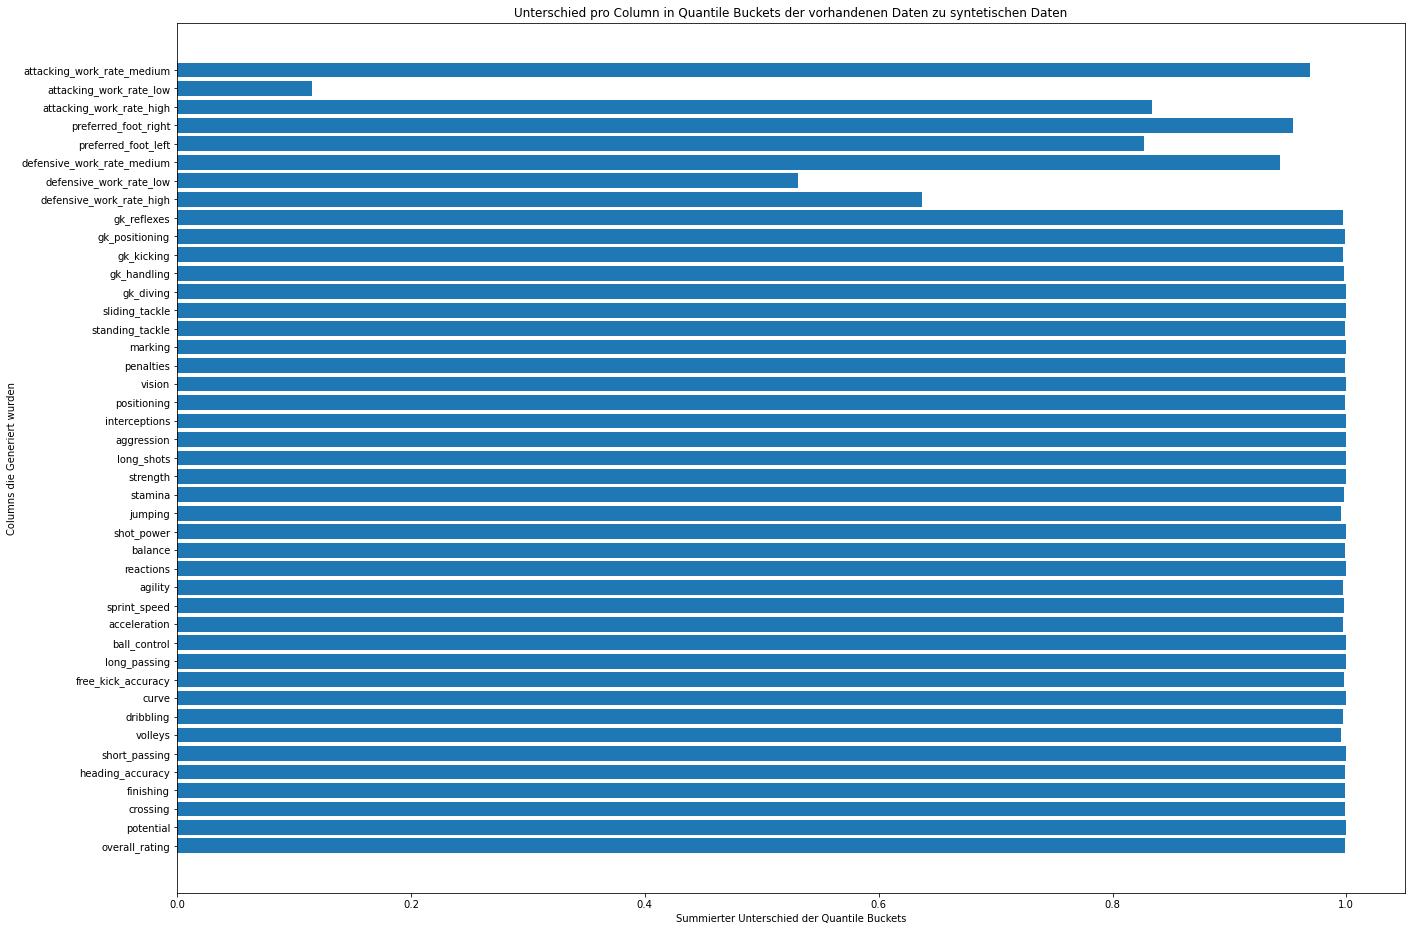

In [16]:
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [17]:
print(f'Overall accuracy: {sum(res) / len(res)}')

Overall accuracy: 0.948002720205482


In [18]:
new_df[new_df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium


In [19]:
df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
df[df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
6170,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,...,14.0,8.0,0,1,0,1,0,0,0,1


In [20]:
# Ich versuche jetzt, ein Generator Modell zu erstellen welches mir neue Daten anhand eines Noise Vektors generiert. 
# Der Generator selbst hat die Original Daten nie gesehen, er nimmt einfach nur Random entgegen und basierend darauf erstellt er etwas. 
# Wie gut das Ergebnis ist, bestimmt später der Discriminator, den ich vermutlich erst später implementiere.

# Zu beginn ist das Ziel, ein super einfachen Generator zu erstellen, der mir basierend auf die eingehende Anzahl an spalten "random" Ausgaben erzeugt. Logischerweise noch super random da 0 trainiert

In [87]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [22]:
def make_generator_model(df):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    # model.add(layers.BatchNormalization()) # BN macht man meist nur bei CNNs..
    model.add(layers.LeakyReLU())
    
    #model.add(layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # => None ist batch size, rest ist der Shape den wir haben wollen
    
    #model.add(layers.Flatten())
    model.add(layers.Dense(256, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [23]:
train_df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
generator = make_generator_model(train_df)

noise = tf.random.normal([1, 100])

generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[ 0.03564275,  0.03442664,  0.04022423,  0.13406369,  0.04377775,
        -0.05957936,  0.11231715,  0.03318175,  0.19854365,  0.08581836,
         0.0271484 ,  0.02881761,  0.04667263, -0.01828503, -0.07976975,
         0.14262988, -0.03655481, -0.02161943, -0.09986396,  0.01051828,
        -0.06593981,  0.1104662 ,  0.10282608,  0.01490093,  0.03554271,
        -0.15393597, -0.00867462, -0.0547784 , -0.03920879,  0.00332723,
         0.0752784 ,  0.02403938, -0.01417533, -0.10729344,  0.09223479,
        -0.00136917, -0.0849816 , -0.07160039,  0.0281287 , -0.04262019,
        -0.05800738,  0.02946633, -0.07821432]], dtype=float32)>

In [24]:
def make_discriminator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model(train_df)
decision = discriminator(generated_data)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00235769]], dtype=float32)>

In [26]:
# Cookie Cutter aus dem DCGAN Notebook
lerning_rate = 0.001
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(lerning_rate)

checkpoint_dir = './checkpoints/dcgan_soccer_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)


seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [48]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [49]:
def train(dataset, epochs, output=True):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        if output:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        #if (epoch +1) % 199 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
        
        if output:
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    if output:   
        display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    print(predictions.shape)

In [31]:
from sklearn import preprocessing

x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_train_df = pd.DataFrame(x_scaled)

In [32]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_train_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
train(train_dataset, EPOCHS)

(16, 43)
Time for epoch 50 is 0.1296536922454834 sec


In [34]:
noise = tf.random.normal([9907, 100])

generated_data = generator(noise, training=False)
generated_data = min_max_scaler.inverse_transform(generated_data)

In [35]:
gan_df = pd.DataFrame(data=generated_data, columns=column_names).astype("float")

158.74306527267538
Overall accuracy: 0.5649865080019814


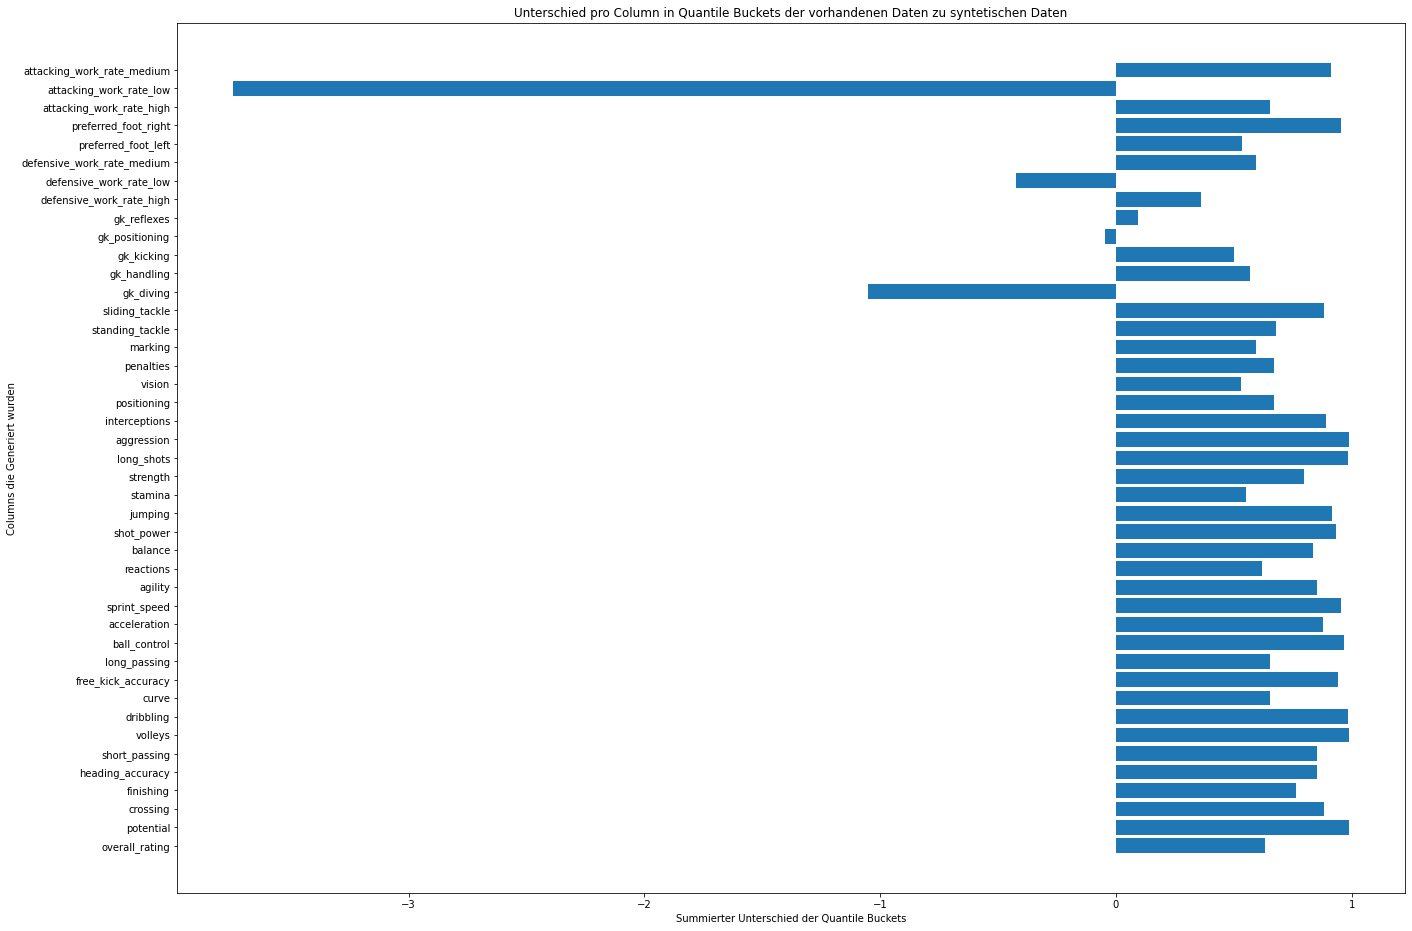

In [36]:
res, dif_total = compare_two_dataframe(gan_df, train_df, column_names, 100)
print(dif_total)
print(f'Overall accuracy: {sum(res) / len(res)}')
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [37]:
gan_df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,46.178411,72.382699,68.200313,65.432090,69.835660,54.774329,45.896013,59.111874,35.503956,50.332918,...,-0.119798,9.364582,0.333506,-0.105767,1.222738,0.516516,0.769212,0.334078,-0.240908,0.753622
1,43.550627,75.687843,69.354406,73.865100,80.932408,61.711743,54.311309,68.258309,45.403112,68.300463,...,7.894093,7.074194,0.541152,-0.071153,1.543810,0.599230,0.986806,0.430743,-0.184518,0.912984
2,41.655765,68.712453,53.396549,49.258308,49.131725,48.980542,38.725984,51.088416,30.594272,44.027101,...,0.882265,-0.061010,0.316552,-0.016972,0.997981,0.413232,0.592020,0.295605,-0.126699,0.613226
3,44.181059,66.038969,54.659144,55.347230,57.686965,47.200104,42.719516,51.795264,37.412561,50.281136,...,3.372350,4.558977,0.417670,-0.030004,1.236552,0.450896,0.785567,0.266461,-0.120210,0.793445
4,42.181787,74.344963,61.747833,60.024343,67.122712,54.057987,46.697837,58.700322,31.225504,53.952484,...,0.612048,-0.596761,0.407149,-0.020162,1.223216,0.503344,0.714942,0.356111,-0.190512,0.717253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,47.217575,64.978205,47.005938,49.622061,61.210276,43.560415,33.005415,48.482119,25.937760,46.956857,...,-2.012050,8.309748,0.344315,-0.029045,1.028846,0.442783,0.640450,0.272526,-0.020424,0.767692
9903,40.345348,66.048189,46.479992,47.428974,52.253080,44.903321,41.415669,48.043841,25.689163,46.115582,...,-2.728619,-4.363318,0.372779,-0.017599,0.937157,0.351673,0.495719,0.278461,-0.120634,0.611235
9904,44.569734,68.042696,52.130550,54.259155,73.443273,51.945880,45.146086,53.031119,32.544074,52.018338,...,-6.259028,-2.529001,0.430432,-0.001561,1.119213,0.435016,0.632604,0.327339,-0.182280,0.737564
9905,44.253969,70.888869,54.123570,56.278569,79.490767,52.230229,45.038078,56.373049,31.882755,57.479482,...,-3.248045,-0.277049,0.487935,0.002850,1.231015,0.468117,0.728858,0.339191,-0.097849,0.796994


In [38]:
gan_df[gan_df.overall_rating < 30]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium


In [39]:
train_df[train_df.overall_rating > 80]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
14,82.0,85.0,75.0,75.0,58.0,83.0,79.0,81.0,70.0,70.0,...,10.0,8.0,1,0,0,0,1,1,0,0
55,82.0,82.0,75.0,72.0,77.0,73.0,69.0,86.0,69.0,57.0,...,7.0,15.0,0,0,1,0,1,0,0,1
429,82.0,85.0,86.0,59.0,64.0,77.0,61.0,82.0,73.0,59.0,...,12.0,5.0,0,0,1,1,0,1,0,0
479,83.0,87.0,70.0,86.0,76.0,80.0,82.0,85.0,74.0,73.0,...,5.0,6.0,1,0,0,0,1,1,0,0
498,86.0,87.0,77.0,83.0,65.0,79.0,78.0,88.0,78.0,78.0,...,12.0,13.0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10867,82.0,84.0,72.0,72.0,46.0,79.0,74.0,92.0,84.0,78.0,...,7.0,7.0,0,0,1,0,1,0,0,1
10880,82.0,83.0,13.0,13.0,10.0,40.0,8.0,15.0,12.0,13.0,...,76.0,86.0,0,0,1,0,1,0,0,1
10911,85.0,85.0,67.0,82.0,74.0,86.0,68.0,81.0,80.0,85.0,...,12.0,8.0,0,1,0,0,1,0,0,1
10916,82.0,84.0,77.0,79.0,49.0,81.0,67.0,86.0,83.0,77.0,...,9.0,9.0,0,0,1,0,1,0,0,1


In [40]:
# undo, nur ein quick work arround da fehler oben:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

# pd.get_dummies(s).idxmax(1)

def unsolve_one_hot(df, hot_cols):
    copy = df.copy()
    for col in hot_cols:
        loop_cols = df.filter(like=col).columns
        res = df[loop_cols].max(1)        
        copy[col] = pd.get_dummies(df[loop_cols]).idxmax(1).map(lambda x: x.lstrip(col).lstrip('_'))
        copy = copy.drop(loop_cols, axis=1)
    
    return copy
                

In [41]:
encoded = unsolve_one_hot(gan_df, df_one_hot_list)
encoded[encoded.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,defensive_work_rate,preferred_foot,attacking_work_rate


In [42]:
# Ok, das Ziel ist es jetzt, die Spieler Tabelle zu generieren.

#1.) Laden der OG Daten:
con = sqlite3.connect("SoccerDataset/database.sqlite")
player_train_df = pd.read_sql_query('SELECT * from Player', con)
con.close()

In [43]:
#2.) One-Hot Encoden von Spalten. Bei den Spielern nicht nötigt, da es keine Attrs. gibt
#3.) Vorbereiten anderer Datentypen, die Generiert werden sollen. Hier z.B. Geburtsdatum
player_train_df['birthday'] = pd.to_datetime(player_train_df['birthday'])
player_train_df['birthday'] = player_train_df.birthday.values.astype(np.int64) // 10 ** 9

In [44]:
#4.) DF erstellen, über Daten die generiert werden sollen. Hier ist es relativ einfach 
training_cols = ['birthday', 'height', 'weight']
training_df = player_train_df[training_cols]

In [45]:
#5.) Normalizieren der Daten, hier mal ein versuch mit SKLearn vll kann man es damit dann auch besser rückgängig machen:
from sklearn import preprocessing

x = training_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)

In [46]:
#6.) Erstellen der benötigten Modelle, ich versuche es so zu machen, dass "ein" Modell für alle Situationen erstellt werden kann. Aber es muss immer neu trainiert werden...
generator = make_generator_model(norm_df)
discriminator = make_discriminator_model(norm_df)

BUFFER_SIZE = 11060
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [50]:
#7.) Magic
train(train_dataset, EPOCHS)

(16, 3)
Time for epoch 50 is 0.0688161849975586 sec


In [51]:
#8.) Erstellen der Daten
noise = tf.random.normal([9907, 100]) #Wir hatten 9907 Spieler Attrs. deswegen auch mal so viele Spieler generieren!
generated_data = generator(noise, training=False)

In [52]:
#9.) Dataframe erstellen, dass dauert bissel hart lange (im Verhältnis)
generated_data = min_max_scaler.inverse_transform(generated_data)
res_df = pd.DataFrame(data=generated_data, columns=training_cols).astype("float")

In [53]:
#10.) OPTIONAL: Zurückwandeln der geänderten Zahlenwerte (hier birthday)
res_df['birthday'] = pd.to_datetime(res_df['birthday'], unit='s')

In [54]:
res_df.loc[res_df.weight > 210]

,birthday,height,weight
507,1978-08-11 10:51:21.280517578,180.929049,212.982901
687,1979-12-12 17:02:29.299907684,182.132401,214.359488
2404,1981-03-03 22:35:51.342773438,183.038950,210.631485
6751,1975-07-11 01:23:14.053459167,181.277851,215.142004
8670,1979-01-25 23:55:18.432426453,183.272805,217.152992
8878,1974-03-30 23:18:47.754306778,178.208126,212.982751
9455,1979-07-06 17:22:06.983642578,180.771633,210.206648


In [55]:
import namegenerator
import random 

def gen_name():
    name = namegenerator.gen()
    count = 10
    if random.randrange(0, 10) == 1:
        count = 1
    name = name.replace('-', ' ', count)
    name = " ".join(w.capitalize() for w in name.split())
    
    part = name.split(' ')
    return part[0] + ' ' + part[1]
    
gen_name()

'Skinny Alizarin'

In [56]:
names = []
for i in range(9907):
    names.append(gen_name())

In [57]:
res_df['Names'] = names

In [58]:
res_df

,birthday,height,weight,Names
0,1976-06-13 16:15:27.400588989,175.933681,189.786222,Seedy Flax
1,1977-11-14 17:37:37.786560059,180.112726,199.909711,Hasty Sangria
2,1975-12-28 21:35:20.805072784,174.885524,190.332941,Snappy Ultramarine
3,1976-04-15 13:17:09.099655151,176.236045,183.859574,Scummy Lilac
4,1976-05-26 05:14:15.186080933,176.125940,182.720782,Pretty Periwinkle
...,...,...,...,...
9902,1976-12-08 09:40:55.593681335,176.641349,188.730943,Surly Black
9903,1976-05-15 15:10:23.995971680,176.616065,188.080546,Pokey White-tarsier
9904,1977-09-11 15:29:32.101593018,176.812956,188.883115,Freaky Razzmatazz
9905,1976-02-18 23:38:53.128738403,175.449347,177.898293,Bumpy Eggplant


In [59]:
def distance(d1, d2, limit):
    diff = []
    diff_ab = []
    for l1, l2 in zip(d1, d2):
        if not isinstance(l1, str) and not isinstance(l2, str):
            diff.append(l1 - l2)
            diff_ab.append(l1 / l2 < (1 + limit) and l1 / l2 > (1 - limit))
        else:
            diff.append("-")
            diff_ab.append("-")  
            
    return (diff, diff_ab)

def count_trues(diff_list_ab):
    total = 0
    total_hits = 0
    for l in diff_list_ab:
        if l:
            total_hits += 1
        if l != '-':
            total += 1 
    return (total, total_hits)

def compare_min_max(original, generated, limit = 0.15):
    omins = [m for m in original.min()]
    omaxs = [m for m in original.max()]
    gmins = [m for m in generated.min()]
    gmaxs = [m for m in generated.max()]
    
    diff_min, diff_min_ab = distance(omins, gmins, limit)
    diff_max, diff_max_ab = distance(omaxs, gmaxs, limit)
    data = [omins, gmins, diff_min, diff_min_ab, omaxs, gmaxs, diff_max, diff_max_ab]
    
    min_total, min_total_hits = count_trues(diff_min_ab)
    max_total, max_total_hits = count_trues(diff_max_ab)
    total = min_total + max_total
    hits = min_total_hits + max_total_hits
    percent = hits / total
    
    print("Total number labels: {0}\nNumber of correct labels:{1}\nAccuracy:{2:2.2f}".format(total, hits, percent))    
    return (total, hits, percent)#pd.DataFrame(data=data, columns=original.columns, index=['OGMins', 'GenMin', 'DiffMin', 'DiffMinLimit', 'OGMax', 'GenMax', 'DiffMax', 'DiffMaxLimit']).T

In [60]:
stats_df = unsolve_one_hot(train_df, ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate'])

In [61]:
res = compare_min_max(stats_df, encoded)

Total number labels: 70
Number of correct labels:16
Accuracy:0.23


In [62]:
res

(70, 16, 0.22857142857142856)

In [63]:
# Hier wäre jetzt sowas cool wie ein durchprobieren von verschiedenen Dingen. 
con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
og_train_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [64]:
train_df = prepare_dataframe(og_train_df)

In [65]:
train_df = train_df.loc[:, 'overall_rating':'attacking_work_rate_medium']

In [66]:
def make_cus_generator_model(df, modelType):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    model.add(layers.LeakyReLU())    

    if modelType > 4:
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU()) 
    
    if modelType > 3:
        model.add(layers.Dense(1024, use_bias = False))
        model.add(layers.LeakyReLU())   
    
    if modelType > 2:
        model.add(layers.Dense(512, use_bias = False))
        model.add(layers.LeakyReLU())   
    
    if modelType > 1:
        model.add(layers.Dense(256, use_bias = False))
        model.add(layers.LeakyReLU())
    
    if modelType > 0:
        model.add(layers.Dense(128, use_bias = False))
        model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [67]:
def make_cus_discriminator_model(df, modelType):
    model = tf.keras.Sequential()

    if modelType == 5:
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 4:
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 3:
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU()) 
    
    if modelType == 2:
        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
        
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())  
    
    if modelType == 1:
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU())        
    
    if modelType == 0:
        model.add(layers.Dense(128))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(256))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [68]:
from sklearn import preprocessing

x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)

In [88]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
training_cols = list(train_df.columns)

res = []

for gens in range(5): # Number of possible Gen Models 5
    for disc in range(6): # Number of possible Disc Models 6
        generator = make_cus_generator_model(norm_df, gens)
        discriminator = make_cus_discriminator_model(norm_df, disc)
        
        @tf.function
        def train_step(images):
            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(images, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        train(train_dataset, EPOCHS * 10, False)
        display.clear_output(wait=True)
        
        noise = tf.random.normal([9907, 100])
        generated_data = generator(noise, training=False)
        
        generated_data = min_max_scaler.inverse_transform(generated_data)
        res_df = pd.DataFrame(data=generated_data, columns=training_cols).astype("float")
        res_df = unsolve_one_hot(res_df, ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate'])
        print("Generator Model: {0} with Discriminator Model: {1}".format(gens, disc))
        compare = compare_min_max(train_df, res_df)
        res.append(((gens, disc), compare))

ResourceExhaustedError: OOM when allocating tensor with shape[9907,11008] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:LeakyRelu]

In [76]:
old

[((0, 0), (70, 11, 0.15714285714285714)),
 ((0, 1), (70, 14, 0.2)),
 ((0, 2), (70, 7, 0.1)),
 ((0, 3), (70, 20, 0.2857142857142857)),
 ((0, 4), (70, 15, 0.21428571428571427)),
 ((0, 5), (70, 12, 0.17142857142857143)),
 ((1, 0), (70, 18, 0.2571428571428571)),
 ((1, 1), (70, 20, 0.2857142857142857)),
 ((1, 2), (70, 22, 0.3142857142857143)),
 ((1, 3), (70, 18, 0.2571428571428571)),
 ((1, 4), (70, 11, 0.15714285714285714)),
 ((1, 5), (70, 20, 0.2857142857142857)),
 ((2, 0), (70, 24, 0.34285714285714286)),
 ((2, 1), (70, 21, 0.3)),
 ((2, 2), (70, 18, 0.2571428571428571)),
 ((2, 3), (70, 27, 0.38571428571428573)),
 ((2, 4), (70, 18, 0.2571428571428571)),
 ((2, 5), (70, 16, 0.22857142857142856)),
 ((3, 0), (70, 18, 0.2571428571428571)),
 ((3, 1), (70, 15, 0.21428571428571427)),
 ((3, 2), (70, 19, 0.2714285714285714)),
 ((3, 3), (70, 21, 0.3)),
 ((3, 4), (70, 21, 0.3)),
 ((3, 5), (70, 19, 0.2714285714285714)),
 ((4, 0), (70, 17, 0.24285714285714285)),
 ((4, 1), (70, 15, 0.21428571428571427)),


In [78]:
old2

[((0, 0), (70, 13, 0.18571428571428572)),
 ((0, 1), (70, 13, 0.18571428571428572)),
 ((0, 2), (70, 18, 0.2571428571428571)),
 ((0, 3), (70, 12, 0.17142857142857143)),
 ((0, 4), (70, 19, 0.2714285714285714)),
 ((0, 5), (70, 9, 0.12857142857142856)),
 ((1, 0), (70, 20, 0.2857142857142857)),
 ((1, 1), (70, 27, 0.38571428571428573)),
 ((1, 2), (70, 17, 0.24285714285714285)),
 ((1, 3), (70, 25, 0.35714285714285715)),
 ((1, 4), (70, 19, 0.2714285714285714)),
 ((1, 5), (70, 13, 0.18571428571428572)),
 ((2, 0), (70, 14, 0.2)),
 ((2, 1), (70, 20, 0.2857142857142857)),
 ((2, 2), (70, 15, 0.21428571428571427)),
 ((2, 3), (70, 23, 0.32857142857142857)),
 ((2, 4), (70, 15, 0.21428571428571427)),
 ((2, 5), (70, 10, 0.14285714285714285)),
 ((3, 0), (70, 18, 0.2571428571428571)),
 ((3, 1), (70, 13, 0.18571428571428572)),
 ((3, 2), (70, 13, 0.18571428571428572)),
 ((3, 3), (70, 24, 0.34285714285714286)),
 ((3, 4), (70, 11, 0.15714285714285714)),
 ((3, 5), (70, 10, 0.14285714285714285)),
 ((4, 0), (70, 

In [85]:
res

[]

In [94]:
import numpy as np

def cal_max(teacher_preds, num_labels):
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=num_labels)
        max_label = np.argmax(label_counts)
        indices.append(max_label)
    return np.array(indices)

def noisy_max(teacher_preds, privacy_loss_lv, n_labels): 
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=n_labels)
        noisy_counts = label_counts + np.random.laplace(np.zeros(len(label_counts)), np.ones(len(label_counts))/privacy_loss_lv, len(label_counts))
        indices.append(np.argmax(noisy_counts))
    return np.array(indices)

In [95]:
for col in column_names:
    df[col] = df[col].astype(int)

In [104]:
from syft.frameworks.torch.dp import pate

# reduce the size, since with all 10k data it will take ages..
p_df = df[:100]
g_df = new_df[:100]

og_df = p_df.to_numpy()
tp_df = g_df.to_numpy()

indices = cal_max(og_df.T, p_df.shape[0])
print(indices)

[ 0  0  0  0  0 77  0  0 15  0  0  0  0  0  0 52  0  0  0  0  0  0  0  0
 56  0  0  0  0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [105]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=tp_df.T, indices=indices, noise_eps=0.001, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 1.4409156831212786
Data Dependent Epsilon: 1.4409156831212786
